# Predictive Modelling: SVM

# Imports

In [1]:
%load_ext autoreload
%autoreload 2

# Pandas and numpy
import pandas as pd
import numpy as np

# 
from IPython.display import display, clear_output
import sys
import time

# Libraries for Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from src.visualization.visualize import plot_corr_matrix, plot_multi, plot_norm_dist, plot_feature_importances

# Some custom tools
from src.data.tools import check_for_missing_vals

# 
from src.models.predict_model import avg_model, run_combinations
#from src.models.train_model import run_combinations 

# Alpaca API
import alpaca_trade_api as tradeapi

# Pickle
import pickle
import os
from pathlib import Path

# To load variables from .env file into system environment
from dotenv import find_dotenv, load_dotenv

from atomm.Indicators import MomentumIndicators
from atomm.DataManager.main import MSDataManager
from atomm.Tools import calc_open_position
from src.visualization.visualize import plot_confusion_matrix
from atomm.Methods import BlockingTimeSeriesSplit, PurgedKFold           


import time

# scikit-learn
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score
from sklearn.model_selection import train_test_split, TimeSeriesSplit

from sklearn.ensemble import BaggingClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# For BayesianHyperparameter Optimization
from atomm.Models.Tuning import search_space, BayesianSearch
from hyperopt import space_eval

# Visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import matplotlib.gridspec as gridspec
#import matplotlib.style as style
from scipy import stats

In [2]:
# Load environment variables
load_dotenv(find_dotenv())

True

## Defining functions

In [3]:
def calc_returns(signals, prices):
    returns = prices[['Close']].pct_change()
    returns['Signal_Strat'] = calc_open_position(signals)
    returns['Cum_Returns_Strat'] = (returns['Signal_Strat'] * returns['Close']).cumsum()
    returns['Cum_Returns_BH'] = returns['Close'].cumsum()
    return returns

## Loading the data

In [4]:
data_base_dir = os.environ.get('DATA_DIR_BASE_PATH')

fname = os.path.join(data_base_dir, 'processed', 'index.h5')
fname = Path(fname)
# Load dataset from HDF storage
with pd.HDFStore(fname) as storage:
    djia = storage.get('nyse/cleaned/rand_symbols')
    y_2c = storage.get('nyse/engineered/target_two_class')
    y_3c = storage.get('nyse/engineered/target_three_class')
    df_moments = storage.get('nyse/engineered/features')
    #print(storage.info())
    
# Create copies of the pristine data
X = df_moments.copy()
y = y_3c.copy()
y2 = y_2c.copy()
prices = djia.copy()

In [5]:
forecast_horizon = [1, 3, 5, 7, 10, 15, 20, 25, 30]
input_window_size = [3, 5, 7, 10, 15, 20, 25, 30]
ti_list = ['macd', 'rsi', 'stoc', 'roc', 'bbu', 'bbl', 'ema', 'atr', 'adx', 'cci', 'williamsr', 'stocd']
symbol_list = df_moments.columns.get_level_values(0).unique()

In [96]:
df_moments.columns.get_level_values(1).unique()

Index(['macd_3', 'rsi_3', 'stoc_3', 'roc_3', 'bbu_3', 'bbl_3', 'ema_3',
       'atr_3', 'adx_3', 'cci_3', 'williamsr_3', 'stocd_3', 'macd_5', 'rsi_5',
       'stoc_5', 'roc_5', 'bbu_5', 'bbl_5', 'ema_5', 'atr_5', 'adx_5', 'cci_5',
       'williamsr_5', 'stocd_5', 'macd_7', 'rsi_7', 'stoc_7', 'roc_7', 'bbu_7',
       'bbl_7', 'ema_7', 'atr_7', 'adx_7', 'cci_7', 'williamsr_7', 'stocd_7',
       'macd_10', 'rsi_10', 'stoc_10', 'roc_10', 'bbu_10', 'bbl_10', 'ema_10',
       'atr_10', 'adx_10', 'cci_10', 'williamsr_10', 'stocd_10', 'macd_15',
       'rsi_15', 'stoc_15', 'roc_15', 'bbu_15', 'bbl_15', 'ema_15', 'atr_15',
       'adx_15', 'cci_15', 'williamsr_15', 'stocd_15', 'macd_20', 'rsi_20',
       'stoc_20', 'roc_20', 'bbu_20', 'bbl_20', 'ema_20', 'atr_20', 'adx_20',
       'cci_20', 'williamsr_20', 'stocd_20', 'macd_25', 'rsi_25', 'stoc_25',
       'roc_25', 'bbu_25', 'bbl_25', 'ema_25', 'atr_25', 'adx_25', 'cci_25',
       'williamsr_25', 'stocd_25', 'macd_30', 'rsi_30', 'stoc_30', 'ro

## Imputing missing values

In [6]:
X.shape

(1954, 4800)

In [7]:
check_for_missing_vals(X)

No missing values found in dataframe


Prices values

In [8]:
prices.shape

(1954, 250)

In [9]:
check_for_missing_vals(prices)

No missing values found in dataframe


In [10]:
y_3c.shape

(1954, 450)

In [11]:
check_for_missing_vals(y_3c)

No missing values found in dataframe


In [12]:
y2.shape

(1954, 450)

In [13]:
check_for_missing_vals(y2)

No missing values found in dataframe


No missing values, and sizes of ```y.shape[0]``` and```X.shape[0]``` match.

# Scaling the features

In [14]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [15]:
#scale = MinMaxScaler()
scale = StandardScaler()

In [16]:
scaled = scale.fit_transform(X)

In [17]:
scaled.shape

(1954, 4800)

In [50]:
#X_scaled = pd.DataFrame(data=scaled, columns=X.columns)
X_scaled = X

# Train-Test Split

In [19]:
# Use 70/30 train/test splits
test_p = .3

In [30]:
# Scaled, three-class
test_size = int((1 - test_p) * X_scaled.shape[0])
X_train, X_test, y_train, y_test = X_scaled[:test_size], X_scaled[test_size:], y_3c[:test_size], y_3c[test_size:]
prices_train, prices_test = djia[:test_size], djia[test_size:]

In [51]:
# Unscaled, two-class
test_size = int((1 - test_p) * X.shape[0])
X_train, X_test, y_train, y_test = X[:test_size], X[test_size:], y2[:test_size], y2[test_size:]
prices_train, prices_test = djia[:test_size], djia[test_size:]

In [58]:
# Scaled, two-class
test_size = int((1 - test_p) * X.shape[0])
X_train, X_test, y_train, y_test = X_scaled[:test_size], X_scaled[test_size:], y2[:test_size], y2[test_size:]
prices_train, prices_test = djia[:test_size], djia[test_size:]

In [ ]:
#test_size = test_p
#X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_3c, test_size=test_size, random_state=101)

# Model

In [21]:
symbol_list

Index(['CNC', 'FMC', 'ALGN', 'RTN', 'FAST', 'ETFC', 'ABC', 'PFG', 'AXP', 'PNW',
       'CMS', 'URI', 'PRGO', 'DRI', 'MAS', 'M', 'ZION', 'CINF', 'HIG', 'EOG',
       'ICE', 'CBOE', 'ALL', 'UHS', 'FRT', 'NEM', 'BLL', 'NDAQ', 'CMG', 'JKHY',
       'T', 'QCOM', 'FTI', 'AOS', 'ATVI', 'STT', 'TXN', 'KIM', 'NTAP', 'CHD',
       'WYNN', 'GM', 'SJM', 'MCHP', 'ES', 'KMB', 'GIS', 'EXC', 'IBM', 'MSFT'],
      dtype='object')

In [22]:
symbol = 'ABC'
n1 = 15
n2 = 15
n_estimators = 10
# set up cross validation splits
tscv = TimeSeriesSplit(n_splits=5)
btscv = BlockingTimeSeriesSplit(n_splits=5)
#ppcv = PurgedKFold(n_splits=5)

## Single lookback/lookahead combination

In [102]:
clf_svc1 = OneVsRestClassifier(
    BaggingClassifier(
                    SVC(
                        kernel='rbf',
                        class_weight='balanced'
                    ),
                    max_samples=.4, 
                    n_estimators=n_estimators,
                    n_jobs=-1)
)


clf_svc1.fit(X_train[symbol][[f'{x}_{n}' for x in ti_list]], y_train[symbol][f'signal_{n}'])

OneVsRestClassifier(estimator=BaggingClassifier(base_estimator=SVC(C=1.0,
                                                                   break_ties=False,
                                                                   cache_size=200,
                                                                   class_weight='balanced',
                                                                   coef0=0.0,
                                                                   decision_function_shape='ovr',
                                                                   degree=3,
                                                                   gamma='scale',
                                                                   kernel='rbf',
                                                                   max_iter=-1,
                                                                   probability=False,
                                                                   random_state=None

Accuracy Score:  0.5400340715502555
              precision    recall  f1-score   support

           0       0.91      0.52      0.66       505
           1       0.19      0.68      0.29        82

    accuracy                           0.54       587
   macro avg       0.55      0.60      0.48       587
weighted avg       0.81      0.54      0.61       587



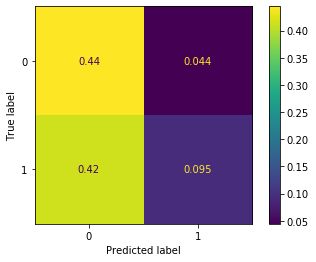

In [103]:
y_pred_svc1 = clf_svc1.predict(X_test[symbol][[f'{x}_{n}' for x in ti_list]])
print('Accuracy Score: ', accuracy_score(y_pred_svc1, y_test[symbol][f'signal_{n}']))
print(classification_report(y_pred_svc1, y_test[symbol][f'signal_{n}']))
plot_confusion_matrix(
    clf_svc1,
    X_test[symbol][[f'{x}_{n}' for x in ti_list]],
    y_test[symbol][f'signal_{n}'],
    normalize='all'
)

## All combinations

## Averaging across all 50 randomly selected stocks

In [172]:
avg_results, scores_dict, preds_dict, params_dict, returns_dict = avg_model(
    symbol_list,
    forecast_horizon,                                 
    input_window_size,                                  
    X_train,    
    X_test,    
    y_train,    
    y_test,    
    prices_test,
    model=clf_svc1,
    silent = False
)

'Leg [50/50]; Elapsed Time 337.0s\n'

,3,5,7,10,15,20,25,30
1,0.413629,0.41339,0.411721,0.412368,0.409506,0.413663,0.414037,0.412129
3,0.406065,0.406814,0.409165,0.407836,0.406951,0.410971,0.411959,0.414514
5,0.402078,0.405486,0.406917,0.405077,0.408893,0.407939,0.406337,0.408382
7,0.40644,0.406746,0.40586,0.402351,0.406678,0.40954,0.406303,0.413799
10,0.407836,0.407359,0.407019,0.40385,0.408041,0.409915,0.408825,0.405451
15,0.402589,0.408484,0.400818,0.402249,0.405554,0.406269,0.39816,0.397683
20,0.396491,0.398705,0.398637,0.394719,0.397922,0.397002,0.39925,0.396559
25,0.397615,0.394617,0.398126,0.396934,0.400443,0.401193,0.399761,0.396899
30,0.396048,0.394991,0.395707,0.392811,0.397683,0.406269,0.401704,0.398535


## Hyperparamter Optimization: GridSearch

In [163]:
gsearch_xgb.best_score_

0.5876651982378854

## Hyperparamter Optimization: Bayesian Optimization

### SVC

In [40]:
n1=15
n2=15
symbol='T'

In [89]:
y_train[symbol][f'signal_{n2}'].value_counts()

1    724
0    643
Name: signal_15, dtype: int64

In [41]:
symbol_list

Index(['CNC', 'FMC', 'ALGN', 'RTN', 'FAST', 'ETFC', 'ABC', 'PFG', 'AXP', 'PNW',
       'CMS', 'URI', 'PRGO', 'DRI', 'MAS', 'M', 'ZION', 'CINF', 'HIG', 'EOG',
       'ICE', 'CBOE', 'ALL', 'UHS', 'FRT', 'NEM', 'BLL', 'NDAQ', 'CMG', 'JKHY',
       'T', 'QCOM', 'FTI', 'AOS', 'ATVI', 'STT', 'TXN', 'KIM', 'NTAP', 'CHD',
       'WYNN', 'GM', 'SJM', 'MCHP', 'ES', 'KMB', 'GIS', 'EXC', 'IBM', 'MSFT'],
      dtype='object')

In [42]:
# Optimizing for accuracy_score

In [93]:
model = SVC
bsearch_svc1, clf_bsearch_svc1, params_bsearch_svc1 = BayesianSearch(
    search_space(model),
    model,
    X_train[symbol][[f'{x}_{n1}' for x in ti_list]], 
    y_train[symbol][f'signal_{n2}'], 
    X_test[symbol][[f'{x}_{n1}' for x in ti_list]],
    y_test[symbol][f'signal_{n2}'],
    num_eval=1000,
    scoring_metric='accuracy_score'
)

100%|██████████| 1000/1000 [12:43<00:00,  1.31it/s, best loss: -0.6436363636363636] 
##### Results #####
Score best parameters:  -0.6436363636363636
Best parameters:  {'C': 105.28486499388394, 'cv': 'btscv', 'gamma': 0.0097275913364278, 'max_samples': 0.6753880233365543, 'model': <class 'sklearn.svm._classes.SVC'>, 'normalize': 0, 'scale': 0}
Test Score (accuracy):  0.5178875638841567
Parameter combinations evaluated:  1000
Time elapsed:  763.4581859111786


Recall Score:  0.5471204188481675
              precision    recall  f1-score   support

           0       0.35      0.46      0.40       205
           1       0.66      0.55      0.60       382

    accuracy                           0.52       587
   macro avg       0.50      0.51      0.50       587
weighted avg       0.55      0.52      0.53       587



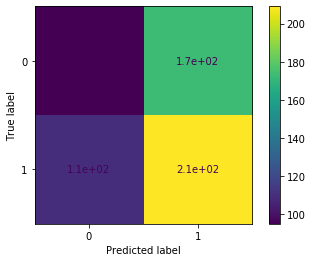

In [94]:
y_pred_bsearch_svc1 = clf_bsearch_svc1.predict(X_test[symbol][[f'{x}_{n1}' for x in ti_list]])
print('Recall Score: ', recall_score(y_pred_bsearch_svc1, y_test[symbol][f'signal_{n2}']))
print(classification_report(y_pred_bsearch_svc1, y_test[symbol][f'signal_{n2}']))
plot_confusion_matrix(
    clf_bsearch_svc1,
    X_test[symbol][[f'{x}_{n1}' for x in ti_list]], y_test[symbol][f'signal_{n2}'],
    
)



In [ ]:
bsearch_xgb2, clf_xgb2, params_xgb2 = BayesianSearch(
    search_space(XGBClassifier),
    model,
    X_train[symbol][[f'{x}_{n}' for x in ti_list]], 
    y_train[symbol][f'signal_{n}'], 
    X_test[symbol][[f'{x}_{n}' for x in ti_list]],
    y_test[symbol][f'signal_{n}'],
    num_eval=30
    scoring_metric='recalls'
)

In [ ]:
y_pred_xgb1 = clf_xgb1.predict(X_test[symbol][[f'{x}_{n}' for x in ti_list]])
%recallll_score(y_pred_xgb1, y_test[symbol][f'signal_{n}'])

### RandomForest

In [66]:
# Accuracy as scoring metric

In [92]:
n=15
symbol='T'

model = RandomForestClassifier
RandomForestClassifier()
bsearch_rf1, clf_rf1, params_rf1  = BayesianSearch(
    search_space(model),
    model,
    X_train[symbol][[f'{x}_{n}' for x in ti_list]], 
    y_train[symbol][f'signal_{n}'], 
    X_test[symbol][[f'{x}_{n}' for x in ti_list]],
    y_test[symbol][f'signal_{n}'],
    num_eval=100,
    scoring_metric='accuracy_score'
)

100%|██████████| 100/100 [04:11<00:00,  2.51s/it, best loss: -0.6181818181818182]
##### Results #####
Score best parameters:  -0.6181818181818182
Best parameters:  {'bootstrap': False, 'criterion': 'entropy', 'cv': 'btscv', 'max_depth': 206, 'max_features': 1, 'min_samples_leaf': 12, 'model': <class 'sklearn.ensemble._forest.RandomForestClassifier'>, 'n_estimators': 200, 'n_jobs': -1}
Test Score (accuracy):  0.5945485519591142
Parameter combinations evaluated:  100
Time elapsed:  251.87587571144104


Accuracy Score:  0.5945485519591142
              precision    recall  f1-score   support

           0       0.36      0.59      0.45       162
           1       0.79      0.60      0.68       425

    accuracy                           0.59       587
   macro avg       0.58      0.59      0.56       587
weighted avg       0.67      0.59      0.62       587



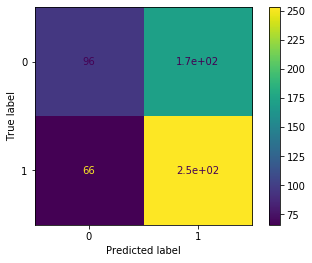

In [93]:
y_pred_rf1 = clf_rf1.predict(X_test[symbol][[f'{x}_{n}' for x in ti_list]])
print('Accuracy Score: ', accuracy_score(y_pred_rf1, y_test[symbol][f'signal_{n}']))
print(classification_report(y_pred_rf1, y_test[symbol][f'signal_{n}']))
plot_confusion_matrix(
    clf_rf1,
    X_test[symbol][[f'{x}_{n}' for x in ti_list]],
    y_test[symbol][f'signal_{n}'],
)



In [ ]:
# Recall as scoring metric

In [94]:
n=15
symbol='T'

model = RandomForestClassifier
RandomForestClassifier()
bsearch_rf2, clf_rf2, params_rf2  = BayesianSearch(
    search_space(model),
    model,
    X_train[symbol][[f'{x}_{n}' for x in ti_list]], 
    y_train[symbol][f'signal_{n}'], 
    X_test[symbol][[f'{x}_{n}' for x in ti_list]],
    y_test[symbol][f'signal_{n}'],
    num_eval=100,
    scoring_metric='recall_score'
)

100%|██████████| 100/100 [04:45<00:00,  2.85s/it, best loss: -0.9049689440993788]
##### Results #####
Score best parameters:  -0.9049689440993788
Best parameters:  {'bootstrap': False, 'criterion': 'gini', 'cv': 'btscv', 'max_depth': 82, 'max_features': 'auto', 'min_samples_leaf': 14, 'model': <class 'sklearn.ensemble._forest.RandomForestClassifier'>, 'n_estimators': 439, 'n_jobs': -1}
Test Score (accuracy):  0.5843270868824532
Parameter combinations evaluated:  100
Time elapsed:  286.13909006118774


Recall Score:  0.5894988066825776
              precision    recall  f1-score   support

           0       0.36      0.57      0.44       168
           1       0.77      0.59      0.67       419

    accuracy                           0.58       587
   macro avg       0.57      0.58      0.55       587
weighted avg       0.66      0.58      0.60       587



419

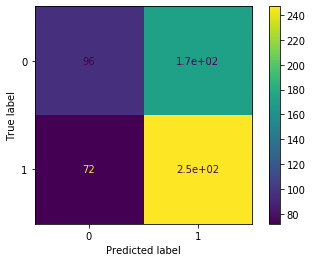

In [97]:
y_pred_rf2 = clf_rf2.predict(X_test[symbol][[f'{x}_{n}' for x in ti_list]])
print('Recall Score: ', recall_score(y_pred_rf2, y_test[symbol][f'signal_{n}']))
print(classification_report(y_pred_rf2, y_test[symbol][f'signal_{n}']))
plot_confusion_matrix(clf_rf2, X_test[symbol][[f'{x}_{n}' for x in ti_list]], y_test[symbol][f'signal_{n}'])


In [ ]:
# f1_score as scoring metric

In [98]:
n=15
symbol='T'

model = RandomForestClassifier
RandomForestClassifier()
bsearch_rf3, clf_rf3, params_rf3  = BayesianSearch(
    search_space(model),
    model,
    X_train[symbol][[f'{x}_{n}' for x in ti_list]], 
    y_train[symbol][f'signal_{n}'], 
    X_test[symbol][[f'{x}_{n}' for x in ti_list]],
    y_test[symbol][f'signal_{n}'],
    num_eval=100,
    scoring_metric='f1_score'
)

100%|██████████| 100/100 [04:30<00:00,  2.70s/it, best loss: -0.6989161224793884]
##### Results #####
Score best parameters:  -0.6989161224793884
Best parameters:  {'bootstrap': False, 'criterion': 'gini', 'cv': 'btscv', 'max_depth': 55, 'max_features': 1, 'min_samples_leaf': 19, 'model': <class 'sklearn.ensemble._forest.RandomForestClassifier'>, 'n_estimators': 316, 'n_jobs': -1}
Test Score (accuracy):  0.606473594548552
Parameter combinations evaluated:  100
Time elapsed:  270.7368309497833


F1 Score:  0.691588785046729
              precision    recall  f1-score   support

           0       0.36      0.62      0.46       157
           1       0.81      0.60      0.69       430

    accuracy                           0.61       587
   macro avg       0.59      0.61      0.57       587
weighted avg       0.69      0.61      0.63       587



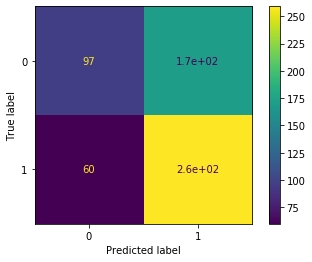

In [99]:
y_pred_rf3 = clf_rf3.predict(X_test[symbol][[f'{x}_{n}' for x in ti_list]])
print('F1 Score: ', f1_score(y_pred_rf3, y_test[symbol][f'signal_{n}']))
print(classification_report(y_pred_rf3, y_test[symbol][f'signal_{n}']))
plot_confusion_matrix(
    clf_rf3, X_test[symbol][[f'{x}_{n}' for x in ti_list]],
    y_test[symbol][f'signal_{n}'])



In [ ]:
# precision_score as scoring metric

In [32]:
n=15
symbol='T'

model = RandomForestClassifier
RandomForestClassifier()
bsearch_rf4, clf_rf4, params_rf4  = BayesianSearch(
    search_space(model),
    model,
    X_train[symbol][[f'{x}_{n}' for x in ti_list]], 
    y_train[symbol][f'signal_{n}'], 
    X_test[symbol][[f'{x}_{n}' for x in ti_list]],
    y_test[symbol][f'signal_{n}'],
    num_eval=25,
    scoring_metric='precision_score'
)

100%|██████████| 25/25 [01:12<00:00,  2.91s/it, best loss: -0.5971743426052591]
##### Results #####
Score best parameters:  -0.5971743426052591
Best parameters:  {'bootstrap': False, 'criterion': 'gini', 'cv': 'btscv', 'max_depth': 177, 'max_features': 'auto', 'min_samples_leaf': 15, 'model': <class 'sklearn.ensemble._forest.RandomForestClassifier'>, 'n_estimators': 330, 'n_jobs': -1}
Test Score (accuracy):  0.5911413969335605
Parameter combinations evaluated:  25
Time elapsed:  73.63188314437866


Precision Score:  0.6618215709594274
              precision    recall  f1-score   support

           0       0.37      0.58      0.45       168
           1       0.78      0.59      0.67       419

    accuracy                           0.59       587
   macro avg       0.57      0.59      0.56       587
weighted avg       0.66      0.59      0.61       587



array([[ 98, 170],
       [ 70, 249]])

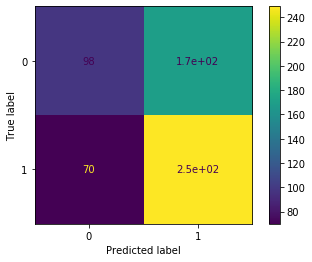

In [33]:
y_pred_rf4 = clf_rf4.predict(X_test[symbol][[f'{x}_{n}' for x in ti_list]])
print('Precision Score: ', precision_score(y_pred_rf4, y_test[symbol][f'signal_{n}'], average='weighted'))
print(classification_report(y_pred_rf4, y_test[symbol][f'signal_{n}']))
plot_confusion_matrix(
    clf_rf4,
    X_test[symbol][[f'{x}_{n}' for x in ti_list]],
    y_test[symbol][f'signal_{n}']
)
confusion_matrix(y_test[symbol][f'signal_{n}'], y_pred_rf4)


## Running on all 50 stocks on best model

In [ ]:
#best_params = {'bootstrap': False, 'criterion': 'gini', 'max_depth': 218, 'max_features': 1, 'min_samples_leaf': 19, 'n_estimators': 423}
#model_2a = (n_jobs=-1, **params_rf4)
avg_results, scores_dict, preds_dict, params_dict, returns_dict = avg_model(  
    symbol_list,
    forecast_horizon,                                 
    input_window_size,
    ti_list,
    X_train,    
    X_test,    
    y_train,    
    y_test,    
    prices_test,
    model=clf_rf4,
    silent = False
)

'Leg [49/50]; Elapsed Time 2813.0s\n'

,3,5,7,10,15,20,25,30
1,0.505093,0.500817,0.50106,0.50193,0.499392,0.501617,0.499809,0.500921
3,0.503007,0.507944,0.504954,0.502903,0.50259,0.507145,0.50193,0.501373
5,0.504363,0.505302,0.511421,0.514411,0.51003,0.508396,0.508779,0.514376
7,0.505789,0.510274,0.508918,0.505163,0.512881,0.512951,0.509822,0.516566
10,0.509404,0.513855,0.510934,0.508605,0.514063,0.512221,0.517262,0.513716
15,0.515975,0.51236,0.516984,0.512638,0.517227,0.522824,0.516879,0.512916
20,0.518722,0.515523,0.515941,0.512846,0.517748,0.516532,0.512881,0.513437
25,0.519452,0.514619,0.517888,0.518374,0.516601,0.512707,0.507631,0.510552
30,0.522025,0.518096,0.518166,0.518722,0.519278,0.515489,0.516149,0.521434


In [ ]:
#best_params = {'bootstrap': False, 'criterion': 'gini', 'max_depth': 218, 'max_features': 1, 'min_samples_leaf': 19, 'n_estimators': 423}
#model_2a = (n_jobs=-1, **params_rf4)
avg_results, scores_dict, preds_dict, params_dict, returns_dict = avg_model(
    symbol_list,
    forecast_horizon,                                 
    input_window_size,
    ti_list,
    X_train,    
    X_test,    
    y_train,    
    y_test,    
    prices_test,
    model=RandomForestClassifier,
    silent = False,
    hyper_optimize=True,
    n_eval=10,
)